## LOAD LIBRARIES

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json

import warnings
warnings.simplefilter('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

from IPython.display import display, HTML, Image

# 4.0. Modeling 

The modeling in this Notebook mirrors what we performed in our later assignments, involving many classes of models. All the modeling performed in this Notebook is based on Tweet Aggregation by User.

## LOAD ENRICHED DATA

In [5]:
# try to load files locally, if don't exist, we load try to load from Microsoft Azure. 
#We could not upload to Github.com because we are using a private repository and the files were to large.

try:
    with open("data/train_data.json") as datafile:
        data = json.load(datafile)

    train_data = pd.read_json(data)

    with open("data/test_data.json") as datafile:
        data = json.load(datafile)

    test_data = pd.read_json(data)
except Exception as e:
    print("Loading Data from Azure - data files do not exist locally")
    
    train_url = "https://eumarharvardfiles.blob.core.windows.net/cscis109/test_data.json"
    train_content = requests.get(train_url).content

    test_url = "https://eumarharvardfiles.blob.core.windows.net/cscis109/test_data.json"
    test_content = requests.get(test_url).content

    train_data = pd.read_json(json.load(io.StringIO(train_content.decode('utf-8'))))
    test_data = pd.read_json(json.load(io.StringIO(test_content.decode('utf-8'))))
    
print(test_data.shape, test_data.shape)

(167, 9) (167, 9)


## DO EXTRA, FINAL DATA CLEANING

In [6]:
# Fill in NaN in follower count that we missed in earlier cleaning
train_data['followers_count'] =  train_data.where(train_data.followers_count.isnull(), 
                                                  np.mean(train_data.followers_count))

test_data['followers_count'] =  test_data.where(test_data.followers_count.isnull(), 
                                                 np.mean(test_data.followers_count))

# Creat list of features
features = ['avg_intertweet_time', 
            'avg_text_length',
            'count_tweets',
            'followers_count',
            'is_tweet',
            'nlp_count_key_phrases',
            'nlp_sentiment_score']

# Create data matrix for train and test
X_train = train_data[features]
X_test = test_data[features]

# Standardize data matrix (needed for KNN and NN)
original_columns = X_train.columns.values
scaler = StandardScaler().fit(X_train)
X_train_std = pd.DataFrame(scaler.transform(X_train),columns=original_columns)
X_test_std = pd.DataFrame(scaler.transform(X_test),columns=original_columns)

# Create response matrix for train and test
y_train = train_data['is_bot']
y_test = test_data['is_bot']

## BEGIN MODELING

In [7]:
def run_default_model(model_text, model, X_train, y_train, X_test, y_test):
    
    '''
    This function fits a basic/default model and prints accuracy scores.
    model_text input:  displayed in results
    model:  model object that can be fit
    X_train: train data matrix
    y_train:  train response
    X_test:  test data matrix
    y_test:  test response
    '''
    
    # Fit the model
    model_fitted = model.fit(X_train,y_train)
    
    # Use fitted model for predictions
    y_hat_train = model_fitted.predict(X_train)
    y_hat_test = model_fitted.predict(X_test)

    #  Calculate accuracy scores
    accuracy_score_train = accuracy_score(y_train, y_hat_train)
    accuracy_score_test = accuracy_score(y_test, y_hat_test)

    # Show results
    print('Base model: {:s}.\nTraining data accuracy score: {:0.3f}.'.format(model_text,accuracy_score_train))
    print('Testing data accuracy score: {:0.3f}.'.format(accuracy_score_test))
    print()
    
    return([float(accuracy_score_train),float(accuracy_score_test)])

## RUN 7 BASE/DEFAULT MODELS

In [8]:
# Creat array in which to save train and test results
# for base/default modeling
# columns:  model_name, train_score, test_score
default_model_results = np.chararray((7,3),itemsize=30)

In [9]:
# Run default model for KNN
# Save model_text, training and test scores in array for plotting

models = [KNeighborsClassifier(), LogisticRegression(), QuadraticDiscriminantAnalysis(), LinearDiscriminantAnalysis(), 
          DecisionTreeClassifier(), RandomForestClassifier(), AdaBoostClassifier()]
model_texts =['KNN', 'Logistic Regression', 'LDA', 'QDA', 
              'Decision Tree Model', 'Random Forest Classifier', 'AdaBoost Classifier']

default_model_results = pd.DataFrame(columns=["Model", "Training_Result", "Testing_Result"])

for i, model in enumerate(models):
    model_num = i
    model_res = run_default_model(model_texts[i], model, X_train_std, y_train, X_test_std, y_test)   
    default_model_results = default_model_results.append({"Model":model_texts[i],
                                                          "Training_Result":model_res[0],
                                                          "Testing_Result":model_res[1]}, ignore_index=True)


default_model_results

Base model: KNN.
Training data accuracy score: 0.934.
Testing data accuracy score: 0.844.

Base model: Logistic Regression.
Training data accuracy score: 0.886.
Testing data accuracy score: 0.743.

Base model: LDA.
Training data accuracy score: 0.807.
Testing data accuracy score: 0.311.

Base model: QDA.
Training data accuracy score: 0.867.
Testing data accuracy score: 0.743.

Base model: Decision Tree Model.
Training data accuracy score: 1.000.
Testing data accuracy score: 0.868.

Base model: Random Forest Classifier.
Training data accuracy score: 0.994.
Testing data accuracy score: 0.808.

Base model: AdaBoost Classifier.
Training data accuracy score: 1.000.
Testing data accuracy score: 0.934.



,Model,Training_Result,Testing_Result
0,KNN,0.933735,0.844311
1,Logistic Regression,0.885542,0.742515
2,LDA,0.807229,0.311377
3,QDA,0.867470,0.742515
4,Decision Tree Model,1.000000,0.868263
5,Random Forest Classifier,0.993976,0.808383
6,AdaBoost Classifier,1.000000,0.934132


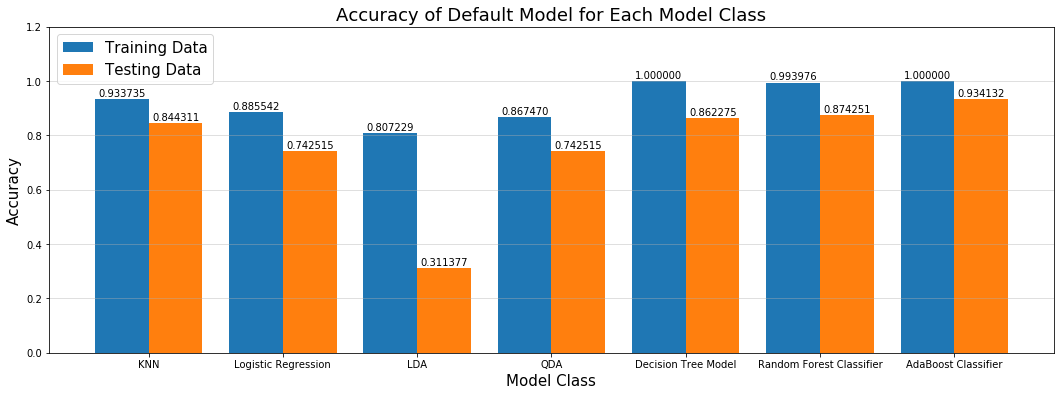

In [35]:
def set_labels(ax):
    """
    This is just a 'helper funtion' used in this question to make
    creating lables a bit more neat.
    input:  ax on which to set labels
    """
    ax.set_title('Accuracy of Default Model for Each Model Class', fontsize=18)
    ax.set_xlabel('Model Class', fontsize=15)
    ax.set_ylabel('Accuracy',fontsize=15)
    ax.set_xticks(x_axis)
    ax.set_xticklabels(x_labels)
    ax.set_ylim([0,1.2])
    ax.grid('True', alpha=.5, axis='y')
    ax.legend(fontsize=15)
    return()

# Get fig, ax for plotting
fig, ax = plt.subplots(figsize=(18,6))

# Create x axis and bar width for plotting from results in array
x_labels = default_model_results['Model']
x_axis = np.arange(len(x_labels))
bar_width = .4

# Create y axis for plotting from results array
y_numbers_train = default_model_results['Training_Result']
y_numbers_test = default_model_results['Testing_Result']

# Plot training and testing score accuracy for each base model
ax.bar(x_axis-bar_width/2,y_numbers_train, width=bar_width, label='Training Data')
ax.bar(x_axis+bar_width/2,y_numbers_test, width=bar_width, label='Testing Data')

# Print values on the bars for training data
for i, label in enumerate(x_labels):
    score = y_numbers_train[i]
    ax.annotate('{:f}'.format(score), (i-.175-bar_width/2, score + 0.01))

# Print values on the bars for testing data
for i, label in enumerate(x_labels):
    score = y_numbers_test[i]
    ax.annotate('{:f}'.format(score), (i-.175+bar_width/2, score + 0.01))
    
# Show titles and labels, etc.
set_labels(ax)

# Save the plot
fig.savefig('Twitter-1.png', bbox_inches='tight')

## TUNE 7 BASE/DEFAULT MODELS WITH GRIDSEARCHCV

In [36]:
# Creat array in which to save train and test results
# for best in class (bic) modeling
# columns:  model_name, train_score, test_score
bic_model_results = np.chararray((7,3),itemsize=30)

In [37]:
def run_best_in_class_model(model_text, model_class, model_parameters, X_train, y_train, X_test, y_test):

    '''
    This function uses GridSerachCV to tune parameters
    This function then fits a best-in-class model and prints accuracy scores.
    and prints accuracy score.
    model_text input:  displayed in results
    model:  model object that can be fit
    X_train: train data matrix
    y_train:  train response
    X_test:  test data matrix
    y_test:  test response
    '''
    
    # Define the GridSearchCV to find the best set of parameters
    model = GridSearchCV(model_class, model_parameters, cv=5)

    # Fit the model using GridSearchCV on training data
    model_fitted = model.fit(X_train,y_train)

    # Show which model was selected by GridSearchCV
    #print(model_fitted.best_estimator_)

    # Create prediction with model selected by GridSearchCV from test data
    y_train_hat = model_fitted.predict(X_train)
    y_test_hat = model_fitted.predict(X_test)

    # Create accuracy score with test data
    accuracy_score_train = accuracy_score(y_train,y_train_hat)
    accuracy_score_test = accuracy_score(y_test,y_test_hat)

    # Show results
    print('Base model: {:s}.\nTraining data accuracy score: {:0.3f}.'.format(model_text,accuracy_score_train))
    print('Testing data accuracy score: {:0.3f}.'.format(accuracy_score_test))
    print()
    
    return(accuracy_score_train, accuracy_score_test, model_fitted.best_estimator_)

In [38]:
# Create dictionary to save the best in class (bic) model objects for use in meta-model
optimized_model = pd.DataFrame(columns=["Model", "Training_Result", "Testing_Result", "Estimators"])

In [39]:
# Create best-in-class KNN model with GridSearchCV tuning
# Save model_text, training and test scores in array for plotting

models = [KNeighborsClassifier(), LogisticRegression(), LinearDiscriminantAnalysis(),
          QuadraticDiscriminantAnalysis(), DecisionTreeClassifier(),
          RandomForestClassifier(), AdaBoostClassifier()]

model_texts =['KNN', 'Logistic Regression', 'LDA', 'QDA',
              'Decision Tree Classifier', 'Random Forest Classifier', 'AdaBoost Classifier']

KNN_params = [{'n_neighbors': [1,3,5,10,15]}]
LOG_params = [{'C':[.0001,.0001,.001,.01,.1,1,10,100,1000,10000]}]
LDA_params = [{'solver':['lsqr'],'shrinkage':[0,.2,.4,.6,.8,1]}]
QDA_params = [{'reg_param': [.0001, .001, .01, .1, 0, 1, 10, 100, 500, 1000, 10000]}]
DTC_params = [{'max_depth': [3,5,7,9,None],'max_features': [1,3,5,None],'min_samples_split': [2,4,8]}]
RFC_params = [{'n_estimators': [10,15,25,40], 'max_depth': [3,5,7,9,None],
               'max_features': [1,3,5,'auto'], 'min_samples_split': [2,4,8]}]
ABC_params = [{'base_estimator':[LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()],
               'learning_rate':[.2,.4,.6,.8,1]}]


model_params = [KNN_params, LOG_params, LDA_params, QDA_params, DTC_params, RFC_params, ABC_params]

for i, model in enumerate(models):
    bic_model_res = run_best_in_class_model(model_texts[i], model, model_params[i], \
                                        X_train_std, y_train, X_test_std, y_test)
    
    optimized_model = optimized_model.append({"Model":model_texts[i],
                                              "Training_Result":bic_model_res[0],
                                              "Testing_Result":bic_model_res[1],
                                              "Estimators":bic_model_res[2]}, ignore_index=True)
optimized_model

Base model: KNN.
Training data accuracy score: 0.952.
Testing data accuracy score: 0.856.

Base model: Logistic Regression.
Training data accuracy score: 0.867.
Testing data accuracy score: 0.737.

Base model: LDA.
Training data accuracy score: 0.867.
Testing data accuracy score: 0.743.

Base model: QDA.
Training data accuracy score: 0.922.
Testing data accuracy score: 0.311.

Base model: Decision Tree Classifier.
Training data accuracy score: 0.952.
Testing data accuracy score: 0.886.

Base model: Random Forest Classifier.
Training data accuracy score: 0.994.
Testing data accuracy score: 0.862.

Base model: AdaBoost Classifier.
Training data accuracy score: 1.000.
Testing data accuracy score: 0.892.



,Model,Training_Result,Testing_Result,Estimators
0,KNN,0.951807,0.856287,"KNeighborsClassifier(algorithm='auto', leaf_si..."
1,Logistic Regression,0.867470,0.736527,"LogisticRegression(C=0.0001, class_weight=None..."
2,LDA,0.867470,0.742515,"LinearDiscriminantAnalysis(n_components=None, ..."
3,QDA,0.921687,0.311377,"QuadraticDiscriminantAnalysis(priors=None, reg..."
4,Decision Tree Classifier,0.951807,0.886228,"DecisionTreeClassifier(class_weight=None, crit..."
5,Random Forest Classifier,0.993976,0.862275,"(DecisionTreeClassifier(class_weight=None, cri..."
6,AdaBoost Classifier,1.000000,0.892216,"((DecisionTreeClassifier(class_weight=None, cr..."


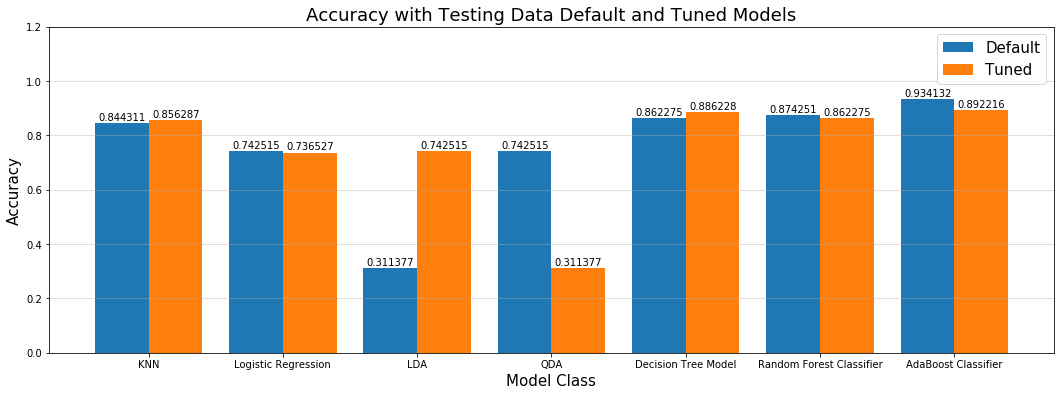

In [40]:
def set_labels(ax):
    """
    This is just a 'helper funtion' used in this question to make
    creating lables a bit more neat.
    input:  ax on which to set labels
    """
    ax.set_title('Accuracy with Testing Data Default and Tuned Models', fontsize=18)
    ax.set_xlabel('Model Class', fontsize=15)
    ax.set_ylabel('Accuracy',fontsize=15)
    ax.set_xticks(x_axis)
    ax.set_xticklabels(x_labels)
    ax.set_ylim([0,1.2])
    ax.grid('True', alpha=.5, axis='y')
    ax.legend(fontsize=15)
    return()

# Get fig, ax for plotting
fig, ax = plt.subplots(figsize=(18,6))

# Create x axis and bar width for plotting from results in array
x_labels = default_model_results['Model']
x_axis = np.arange(len(x_labels))
bar_width = .4

# Create y axis for plotting from testing results
y_numbers_base = default_model_results['Testing_Result']
y_numbers_bic = optimized_model['Testing_Result']

# Plot training and testing score accuracy for each base model
ax.bar(x_axis-bar_width/2,y_numbers_base, width=bar_width, label='Default')
ax.bar(x_axis+bar_width/2,y_numbers_bic, width=bar_width, label='Tuned')

# Print values on the bars for default data
for i, label in enumerate(x_labels):
    score = y_numbers_base[i]
    ax.annotate('{:f}'.format(score), (i-.175-bar_width/2, score + 0.01))

# Print values on the bars for tuned data
for i, label in enumerate(x_labels):
    score = y_numbers_bic[i]
    ax.annotate('{:f}'.format(score), (i-.175+bar_width/2, score + 0.01))
    
# Show titles and labels, etc.
set_labels(ax)

# Save the plot
fig.savefig('Twitter-2.png', bbox_inches='tight')

## CREATE META-MODEL BASED ON 7 TUNED MODELS

**Lacking tuning data for ensemble**

In [41]:
# Save number of training observations
# NOTE:  We are re-using training data
# as opposed to tuning with tuning data
# due to lack of data.  None limitation of
# project.
num_train_observations = len(X_train_std)
num_test_observations = len(X_test_std)

# Initialize dataframes for storing results
ensemble_train = pd.DataFrame()
ensemble_test = pd.DataFrame()

# Initialize arrays for storing results
predictions_train = np.zeros(num_train_observations)
predictions_test = np.zeros(num_test_observations)

#  For each model in ensemble..
for model_name in optimized_model['Model']:
        
    # Get the model selected by GridSearchCV
    model = optimized_model.loc[optimized_model.Model == model_name].Estimators.values[0]

    # Fit the model selected by GridSearchCV 
    # on the training data. This is normally
    # where we would be fitting on tuning data
    # which we don't have.  Arguablly, re-fitting
    # on training is unnessary (done above), 
    # but we are going through this step to be 
    # consistent with what we would do if we 
    # had tuning data.
    model_fitted = model.fit(X_train_std,y_train)
    
    # Generate predictions (as probability of class 1)
    # using each 'bic' model (re-fiitted on training data) 
    # with both the training data and testing data
    y_hat_train = model_fitted.predict_proba(X_train_std)[:,1]
    y_hat_test = model_fitted.predict_proba(X_test_std)[:,1]
  
    # Create a column to store these predictions 
    # for both tuning data and testing data
    df_column_name = "{:s} probability '1'".format(model_name)
    ensemble_train[df_column_name] = y_hat_train
    ensemble_test[df_column_name] = y_hat_test

In [42]:
# Use data matrix from ensemble models as training
# data for RF meta-model
# Save model_text, training and test scores in array for plotting
model_text = "Random Forest"
model_class = RandomForestClassifier()
model_parameters = [{'n_estimators': [15,25,40],
                     'max_depth': [3,5,7,9],
                     'max_features': [1,3,5],
                     'min_samples_split': [2,4,8]
                    }]

ensemble_results_train, ensemble_results_test, ensemble_results_model = \
                                                run_best_in_class_model(model_text, 
                                                                        model_class, 
                                                                        model_parameters, 
                                                                        ensemble_train, 
                                                                        y_train, 
                                                                        ensemble_test, 
                                                                        y_test)

Base model: Random Forest.
Training data accuracy score: 1.000.
Testing data accuracy score: 0.904.



## Create Neural Network

In [43]:
# Convert response variable to categoricals for NN
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat  = to_categorical(y_test, num_classes=2)

In [44]:
# Scale data matrix to make more compatible with Keras
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# Define NN nodes
# Input shape = 7 because we have 7 features in X_train
# Output layer is size 2 with softmax
# activiation because we are doing binomial classification
model_NN= Sequential([
    Dense(7, input_shape=(7,), activation='relu'),
    Dense(4, activation='relu'),
    Dense(3, activation='relu'),
    Dense(2, activation='softmax')
])

In [46]:
# Compile model
# Loss is specified for binary classification
model_NN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model
display(model_NN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 32        
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 15        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 8         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


None

In [47]:
# Fit the model with scaled and categorical data
model_fitted = model_NN.fit(X_train_scaled, y_train_cat, epochs=50, batch_size=32, validation_split = .4)

Train on 99 samples, validate on 67 samples
Epoch 1/50
99/99 [==============================] - 0s 4ms/step - loss: 0.6487 - acc: 0.7071 - val_loss: 0.6620 - val_acc: 0.6567
Epoch 2/50
99/99 [==============================] - 0s 66us/step - loss: 0.6424 - acc: 0.7071 - val_loss: 0.6613 - val_acc: 0.6567
Epoch 3/50
99/99 [==============================] - 0s 81us/step - loss: 0.6368 - acc: 0.7071 - val_loss: 0.6616 - val_acc: 0.6567
Epoch 4/50
99/99 [==============================] - 0s 60us/step - loss: 0.6326 - acc: 0.7071 - val_loss: 0.6610 - val_acc: 0.6567
Epoch 5/50
99/99 [==============================] - 0s 60us/step - loss: 0.6294 - acc: 0.7071 - val_loss: 0.6609 - val_acc: 0.6567
Epoch 6/50
99/99 [==============================] - 0s 91us/step - loss: 0.6259 - acc: 0.7071 - val_loss: 0.6598 - val_acc: 0.6567
Epoch 7/50
99/99 [==============================] - 0s 60us/step - loss: 0.6233 - acc: 0.7071 - val_loss: 0.6574 - val_acc: 0.6567
Epoch 8/50
99/99 [======================

In [48]:
accuracy_score_nn = model_NN.evaluate(X_test_scaled,y_test_cat,batch_size=32)[1]
print('Accuracy score of neural net = {:f}.'.format(accuracy_score_nn))

167/167 [==============================] - 0s 24us/step
Accuracy score of neural net = 0.688623.


# MLPClassifier

In [49]:
from sklearn.neural_network import MLPClassifier

In [50]:
#The parameters of the model has been optimized
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7,2), random_state=1, warm_start=True)

In [51]:
y_pred=clf.fit(X_train_scaled, y_train).predict(X_test_scaled)

In [52]:
#Calculate the accuracy of test data
test_acc=np.sum(y_test.values == y_pred)/ len(y_test)

In [53]:
y_train_pred=clf.fit(X_train_scaled, y_train).predict(X_train_scaled)

In [54]:
#Calculate the accuracy of training data
train_acc=np.sum(y_train.values == y_train_pred)/ len(y_train)

In [55]:
print("The classification accuracy of MLPClassifer on train data is: {:.3f}".format(train_acc))
print("The classification accuracy of MLPClassifer on test data is: {:.3f}".format(test_acc))

The classification accuracy of MLPClassifer on train data is: 0.687
The classification accuracy of MLPClassifer on test data is: 0.689


## FINAL COMPARISON


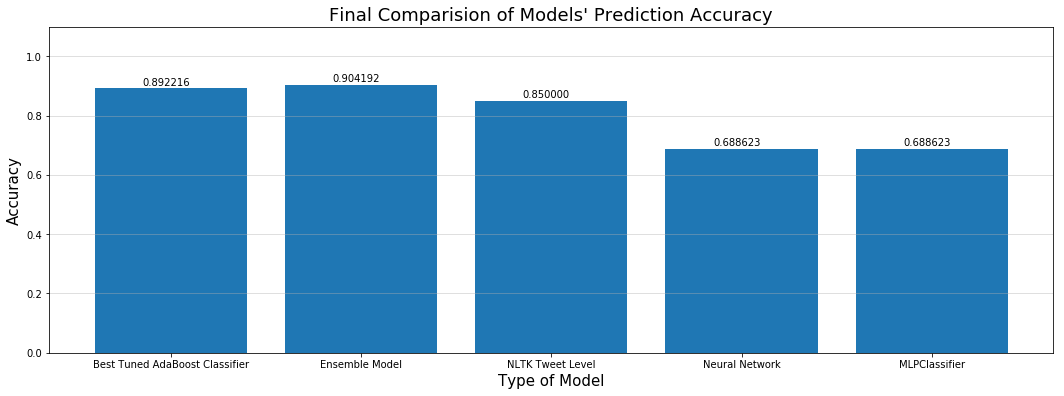

In [56]:
def set_labels(ax):
    """
    This is just a 'helper funtion' used in this question to make
    creating lables a bit more neat.
    input:  ax on which to set labels
    """
    ax.set_title("Final Comparision of Models' Prediction Accuracy", fontsize=18)
    ax.set_xlabel('Type of Model', fontsize=15)
    ax.set_ylabel('Accuracy',fontsize=15)
    ax.set_xticks(x_axis)
    ax.set_xticklabels(x_labels)
    ax.set_ylim([0,1.1])
    ax.grid('True', alpha=.5, axis='y')
    return()


# Find the bic model that did the best among all classes
best_tuned_score = 0
best_tuned_model = ''
for i in range(7):
    if float(optimized_model.loc[i,'Testing_Result']) > best_tuned_score:
        best_tuned_score = float(optimized_model.loc[i,'Testing_Result'])
        best_tuned_model = str(optimized_model.loc[i,'Model'])
    else:
        pass

# Get fig, ax for plotting
fig, ax = plt.subplots(figsize=(18,6))

# Create x axis and bar width for plotting from results in array
x_labels = ['Best Tuned {:s}'.format(best_tuned_model), 'Ensemble Model', 'NLTK Tweet Level','Neural Network', 'MLPClassifier']
x_axis = np.arange(len(x_labels))
bar_width = .8

# Create y axis for plotting from testing results
y_numbers = [best_tuned_score,ensemble_results_test,.85,accuracy_score_nn, test_acc]

# Plot testing score accuracy for each base model
ax.bar(x_axis,y_numbers, width=bar_width)

# Print values on the bars
for i, label in enumerate(x_labels):
    score = y_numbers[i]
    ax.annotate('{:f}'.format(score), (i-.15, score + 0.01))
    
# Show titles and labels, etc.
set_labels(ax)

# Save the plot
fig.savefig('Twitter-3.png', bbox_inches='tight')